In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2
import os
from datetime import datetime
from skimage.restoration import denoise_nl_means, denoise_wavelet
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage import exposure, filters
from scipy import ndimage
import tarfile
import tkinter as tk
from tkinter.ttk import Scale, Label

In [2]:
def extract_tar_to_folder(tar_file_path, output_folder):
    # Create a new folder based on the name of the tar file
    tar_folder_name = os.path.splitext(os.path.basename(tar_file_path))[0]
    new_folder_path = os.path.join(output_folder, tar_folder_name)
    os.makedirs(new_folder_path, exist_ok=True)

    # Extract contents of the tar file into the new folder
    
    with tarfile.open(tar_file_path, 'r') as tar:
        tar.extractall(path=new_folder_path)

    print(f"Extracted contents of {tar_file_path} to {new_folder_path}")
    return new_folder_path

In [4]:
tar_file_path = 'AR11882_2013_10_25_1451_cea_Bt.tar' # Update with your tar file path
output_folder = r"D:\SolarDB-Movies\Raw_Image_folders"  # Update with your desired output folder
input_dir =  extract_tar_to_folder(tar_file_path, output_folder) #extract_tar_to_folder(tar_file_path, output_folder) #Getting our input directory

Extracted contents of AR11882_2013_10_25_1451_cea_Bt.tar to D:\SolarDB-Movies\Raw_Image_folders\AR11882_2013_10_25_1451_cea_Bt


In [5]:
input_dir

'D:\\SolarDB-Movies\\Raw_Image_folders\\AR11882_2013_10_25_1451_cea_Bt'

In [6]:
def get_file_details(path):
  filename = os.path.basename(path)
  list_filename = filename.split(sep = '_')
  Flarefile = list_filename[0]

  TYPE = list_filename[5].split(sep = '.')
  typef = ' '.join([str.upper(i) for i in TYPE]) + ' ' + list_filename[-1].split(sep = '.')[0]
  
  return Flarefile , typef 


In [7]:
Flaredetails = get_file_details(input_dir)
Flaredetails

('AR11882', 'CEA Bt')

In [8]:
filenames = os.listdir(input_dir)
filenames1 = sorted(filenames)

In [9]:
def extract_time(files , index):
  time_string = files[index].split(sep = '.')[3]
  datetime_obj = datetime.strptime(time_string, "%Y%m%d_%H%M%S_TAI")
  # Format the combined date and time
  timestamps = datetime_obj.strftime("%Y-%m-%d %H:%M:%S")
  return timestamps

In [10]:
timestamps = []
for i in range(0, len(filenames1)):
  ts = extract_time(filenames1, i)
  timestamps.append(ts)
timestamps[1]

'2013-10-24 19:24:00'

In [14]:
# Read the data from each FITS file
#images = [fits.getdata(file) for file in glob(input_dir + "/*.fits")]

#For Bt data
images_x = [fits.getdata(file) for file in glob(input_dir + "/*Bx.fits")]
images_y = [fits.getdata(file) for file in glob(input_dir + "/*By.fits")]

In [15]:
len(images_x) , len(images_y)

(129, 129)

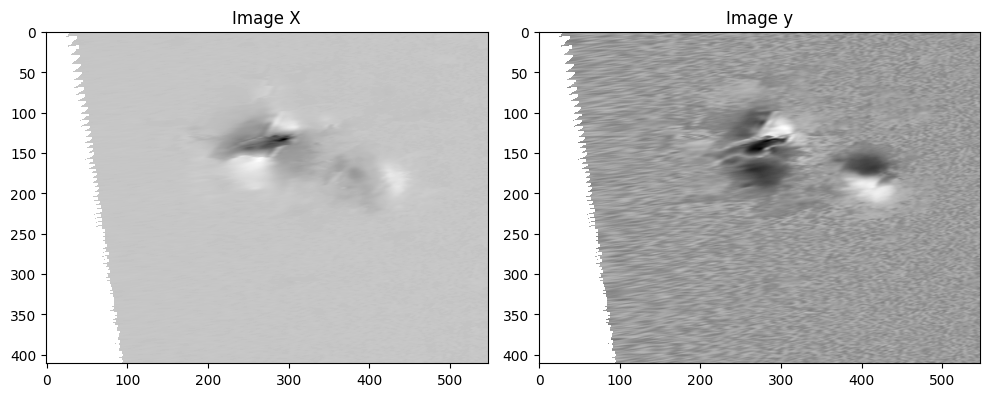

In [16]:
eg_img_X = images_x[1]
eg_img_X = eg_img_X[::-1, :]

eg_img_y = images_y[1]
eg_img_y = eg_img_y[::-1, :]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the images on the subplots
ax1.imshow(eg_img_X, cmap="gray")
ax2.imshow(eg_img_y, cmap="gray")

# Set titles and labels for the subplots
ax1.set_title("Image X")
ax2.set_title("Image y")

plt.tight_layout()
plt.show()

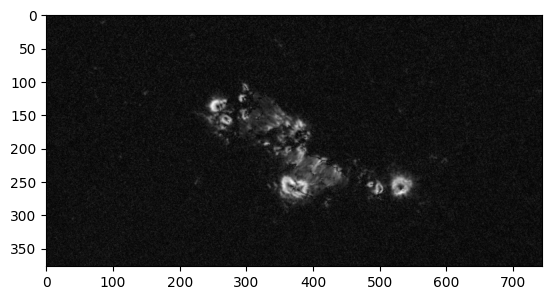

In [95]:
def combine_images(bx_image, by_image):
    combined_image = np.sqrt(bx_image**2 + by_image**2)
    return combined_image

bt_images = []
for i in range(len(images_x)):
    bt_images.append(combine_images(images_x[i], images_y[i]))

plt.imshow(bt_images[2], cmap = 'gray')

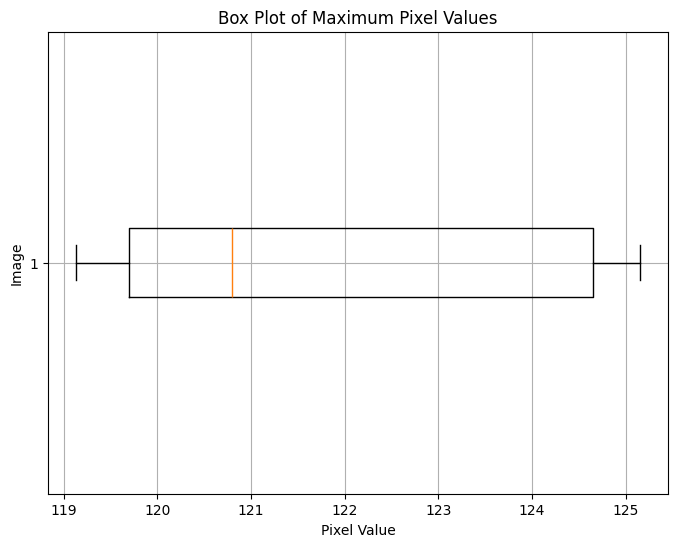

In [13]:
normalized = [cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX) for img in images] ##Imp fuction, firectly use this and skip upper part using
max_values = [img.mean() for img in normalized]

# Create a box plot
plt.figure(figsize=(8, 6))
plt.boxplot(max_values, vert=False)
plt.title('Box Plot of Maximum Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Image')
plt.grid(True)
plt.show()

In [14]:
def filter_images_by_intensity(images, intensity_threshold=250):
    cleaned_files = []
    for image in images:
      # Check if any pixel intensity exceeds the threshold
      if np.mean(image) <= intensity_threshold:
          cleaned_files.append(image)

    return cleaned_files

cleaned = filter_images_by_intensity(normalized)


In [15]:
len(cleaned)

5

In [16]:
highest_shape_image = max(cleaned, key=lambda image: image.size)

print("Image with highest shape:", highest_shape_image.shape)

Image with highest shape: (377, 744)


In [66]:
def fix_image_flashes(image):
  normalized_data = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
  image = normalized_data.astype(np.uint8)
  denoised = cv2.fastNlMeansDenoising(image, None, 3,3, 25)

  thresh = cv2.threshold(denoised, 240, 255, cv2.THRESH_BINARY)[1]

  # Find the contours of the glare
  contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

  # Create a mask of the glare
  mask = np.zeros(image.shape[:2], np.uint8)
  cv2.drawContours(mask, contours, -1, 255, -1)

  # Inpaint the glare
  inpainted_image = cv2.inpaint(image, mask, 0.1, cv2.INPAINT_TELEA)

  return inpainted_image

In [67]:
#plt.imshow(fix_image_flashes(cleaned[80]))

In [17]:
from skimage import exposure, filters

def enhance_image(image):
  image = image.astype(np.uint8)
  normalized_data = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(5, 5))
  data_clahe = clahe.apply(normalized_data)
  equalized_data = exposure.equalize_adapthist(data_clahe) #adaptive histogran thresholding
  filtered_data = filters.median(equalized_data)
  sharpened_data = filters.unsharp_mask(filtered_data, radius=3, amount=50)
  threshold = filters.threshold_otsu(equalized_data) #thresholding with otsu
  binary_data = sharpened_data > threshold

  return binary_data #Final Image

def threshold(pixel):
    if pixel >240:
        return pixel - pixel*0.4
    else:
        return pixel

def filtered_image(image):
  normalized_data = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
  image = normalized_data.astype(np.uint8)
  kernel = np.ones((1,1),np.uint8)
  opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
  filtered_img = ndimage.generic_filter(opening, threshold, size=1)
  return filtered_img

def denoise(image):
  normalized_data = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
  image = image.astype(np.uint8)
  denoised = cv2.fastNlMeansDenoising(image, None, 2, 2, 5)
  return denoised

def update_image(image):
  return filtered_image(image) + enhance_image(image)

def adjust_contrast(image, alpha = 1.0, beta = 0):
    """Adjusts image contrast using linear transformation."""
    adjusted = cv2.convertScaleAbs(image, alpha, beta)
    return adjusted


def adjust_shadows(image, shadow_value, highlight_value):
    """Adjusts image shadows using histogram equalization."""
    '''hist, _ = np.histogram(image, bins=256, range=(0, 255))
    cdf = np.cumsum(hist)
    cdf_normalized = cdf / cdf[-1]
    cdf_mapped = np.interp(image, np.arange(256), cdf_normalized * 255)
    return cdf_mapped.astype(np.uint8)'''
    image = image.astype(np.float32)
    shadow_amount = shadow_value
    highlight_amount = highlight_value
    # Apply the shadow and highlight adjustment
    adjusted_image = cv2.addWeighted(image, 1 - shadow_amount, image, 1 - highlight_amount, 0)

'''def adjust_exposure(image, exposure_value):
    """Adjusts image exposure using gamma correction."""
    eposure = cv2.pow(image , exposure_value)
    return exposure'''

def adjust_sharpness(image, sharpness_value):
    """Adjusts image sharpness using unsharp masking."""
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    blurred_image = cv2.filter2D(image, -1, kernel)
    return cv2.addWeighted(image, 1.0 + sharpness_value, blurred_image, -sharpness_value, 0)

def adjust_highlights(image, highlight_value):
    """Adjusts image highlights using percentile-based thresholding."""
    threshold = np.percentile(image, (100 - highlight_value) * 100)
    return np.clip(image, 0, threshold)

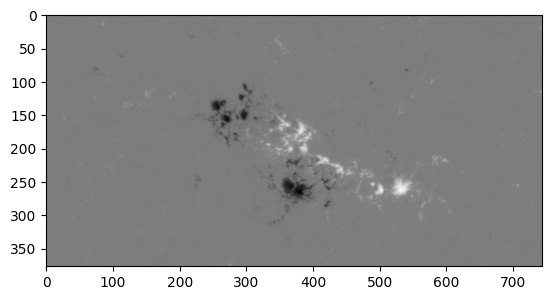

In [18]:
plt.imshow(cleaned[4], cmap = 'gray')

In [23]:
def final_image(image):
    image = image.astype(np.float32)
    new_img = adjust_sharpness(image, 0.01)
    new_img = adjust_contrast(new_img, 0.8, 0.2)
    new_img = new_img**0.9
    return new_img

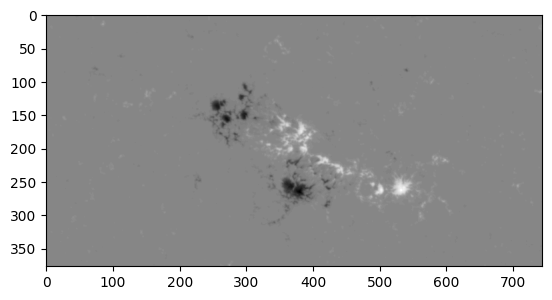

In [24]:
plt.imshow(final_image(cleaned[4]), cmap = 'gray')
#plt.colorbar()

In [30]:
enhanced_list = [img[::-1, :] for img in cleaned]

In [114]:
enhanced_list = [final_image(i) for i in enhanced_list] #Important Function: Apply the final image function to each element of the list.

In [31]:
def save_images(image_list, output_folder, cmap):
    #Saving the Images to the Processed Folder
    os.makedirs(output_folder, exist_ok=True)
    for i, img_array in enumerate(image_list):
        output_file = os.path.join(output_folder, f'image_{i}.png')
        fig, ax = plt.subplots(figsize=(15, 8))
        ax.imshow(img_array, cmap=cmap)
        ax.text(50, 80, timestamps[i] + "\n" + Flaredetails[1], color='black')
        ax.text(600, 80, Flaredetails[0], color='black')
        plt.savefig(output_file)  
        plt.close()

    print(f"Images saved in '{output_folder}' folder.")

output_folder = 'Processed_Image_Folders/' + os.path.basename(input_dir)
save_images(enhanced_list , output_folder, 'gray') #**IMP** Check it carefully

Images saved in 'Processed_Image_Folders/AR11158_2011_02_13_1728_cea_magnetogram' folder.


In [32]:
video_name = ' '.join(Flaredetails) + '.mp4'
video_name = video_name.replace(' ', '_')
print("File name: ", video_name)

File name:  AR11158_CEA_magnetogram.mp4


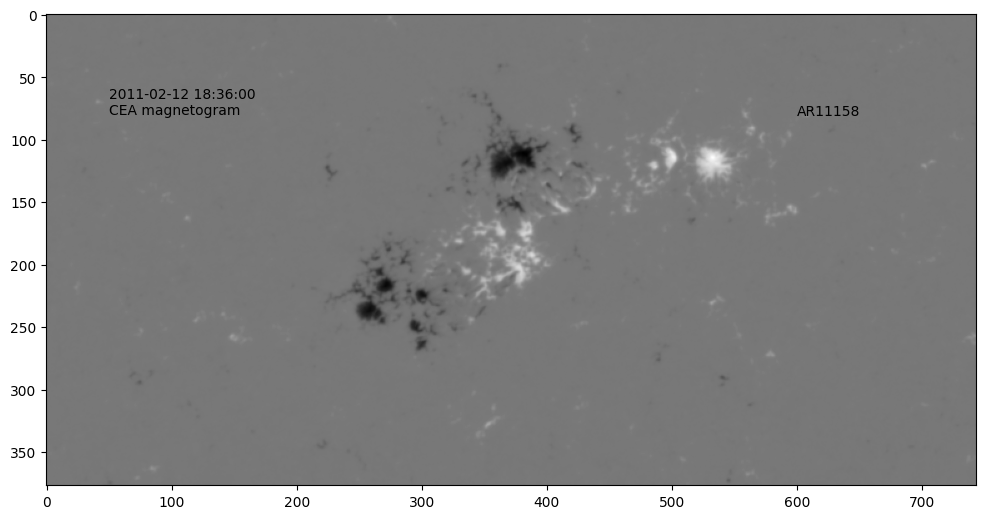

In [35]:
import matplotlib.animation as animation
%matplotlib inline

out_path = 'Movies/' + video_name
fig, ax = plt.subplots(figsize=(12, 7))

ax.set_xlim([0, highest_shape_image.shape[0]])
ax.set_ylim([0, highest_shape_image.shape[1]])

# Add labels to the axes
ax.set_xlabel("E-W (arcsec)")
ax.set_ylabel("S-N (arcsec)")

ax.set_aspect("equal")

# Create an animation function
def update(num, images, texts, flare_info, type_flare, ax):
    # Clear the current axes
    ax.clear()

    # Display the image
    ax.imshow(enhanced_list[num], cmap = 'gray')

    # Add text
    ax.text(50, 80, texts[num] + "\n" + type_flare, color='black')
    ax.text(600, 80, flare_info, color='black')

# Create an animation object
anim = animation.FuncAnimation(fig, update, interval=100, frames = len(enhanced_list), fargs = [enhanced_list, timestamps, Flaredetails[0], Flaredetails[1], ax])

# Save the animation as a video
anim.save(out_path, bitrate = 3000, writer = 'ffmpeg', fps = 5)


In [36]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video controls><source src="{video_url}"></video>""")

show_video(out_path)